In [1]:
import os
import sys

NJET_BLHA='/Users/simon/packages/njet-3.1.1-1L/blha/'
sys.path.append(NJET_BLHA)

import numpy as np
from pstools.rambo import generate, dot
from njettools.njet_interface import *
from nntools.model import Model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# choose the number of training points (will later be split into NN train/test set)
n_training_points = 10000
n_points = 20000 # points for inference
delta_cut = 0.03
n_final = 3
contract_file = 'NJ_contract_ee'+str(n_final)+'j_tree.lh'

In [3]:
# generate 2 -> 3 phase-space points for training
momenta, n_trials = generate(n_final, n_training_points, rts=1000., delta=delta_cut)
momenta = momenta.tolist()

100%|██████████| 10000/10000 [00:01<00:00, 5430.35it/s]


In [4]:
# start the NJet interface
olp = njet.OLP()
status = njet_init(contract_file)

if status == True:
    print ("OLP read in correctly")
else:
    print ("seems to be a problem with the contract file...")

OLP read in correctly


In [5]:
mur = 100.
alphas = 0.118
alpha = 1/137.

In [6]:
NJ_treevals = [];
for pt in range(n_training_points):
    vals = olp.OLP_EvalSubProcess(1, momenta[pt], alphas=alphas, alpha=alpha, mur=mur, retlen=1)
    NJ_treevals.append(vals[0])

In [7]:
def getFKSpartitions(mom):
    nn = len(mom)
    ss = [];
    for i in range(2,nn-1):
        for j in range(i+1,nn):
            #print(i, j, i-2+(j-2)*(j-3)/2)
            ss.append(2*dot(mom[i],mom[j]))
    ss = np.array(ss)
    DD = np.sum(1/ss)
    SS = 1/ss/DD
    return(SS)

In [8]:
parts = getFKSpartitions(momenta[0])
n_FKSsectors = len(parts)

print(parts)
print(np.sum(parts))

[0.38058659 0.22221619 0.39719722]
1.0


In [9]:
NJ_treevals_FKS = []
momenta_FKS = []
for pt in range(n_training_points):
    parts = getFKSpartitions(momenta[pt])
    momenta_FKS.append(parts)
    NJ_treevals_FKS.append(NJ_treevals[pt]*parts)

momenta_FKS = np.array(momenta_FKS)
NJ_treevals_FKS = np.array(NJ_treevals_FKS)

In [10]:
# dump generated data in case NJet and interface not available
np.save("data/NJfks_ee"+str(n_final)+"j_tree_momenta_"+str(delta_cut)+".npy", momenta)
np.save("data/NJfks_ee"+str(n_final)+"j_tree_values_"+str(delta_cut)+".npy", NJ_treevals)
np.save("data/NJfks_ee"+str(n_final)+"j_tree_momenta_FKS_"+str(delta_cut)+".npy", momenta_FKS)
np.save("data/NJfks_ee"+str(n_final)+"j_tree_values_FKS_"+str(delta_cut)+".npy", NJ_treevals_FKS)

# Start from here with pre-generated data #

In [11]:
momenta = np.load("data/NJfks_ee"+str(n_final)+"j_tree_momenta_"+str(delta_cut)+".npy")
NJ_treevals = np.load("data/NJfks_ee"+str(n_final)+"j_tree_values_"+str(delta_cut)+".npy")
momenta_FKS = np.load("data/NJfks_ee"+str(n_final)+"j_tree_momenta_FKS_"+str(delta_cut)+".npy") 
NJ_treevals_FKS = np.load("data/NJfks_ee"+str(n_final)+"j_tree_values_FKS_"+str(delta_cut)+".npy")
n_training_points = len(momenta)
n_FKSsectors = len(momenta_FKS[0])

# First train a basic or "naive" single model to test against #

In [12]:
NN = Model(
    (2+n_final)*4, # train with all momenta components 
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_treevals) # data points from NJet evaluations
)

In [13]:
model, x_mean, x_std, y_mean, y_std = NN.fit(layers=[16,32,16], epoch_interval=100)

processing training data using scaling =  standardise
The training dataset has size (8000, 20)
Epoch 1/10000
8000/8000 [==============================] - 1s 96us/sample - loss: 1.3393 - val_loss: 1.2371
Epoch 101/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0385 - val_loss: 0.1075
Epoch 201/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0126 - val_loss: 0.0583
Epoch 301/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 0.0048 - val_loss: 0.0375
Epoch 401/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0027 - val_loss: 0.0290
Epoch 501/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0017 - val_loss: 0.0250
Epoch 601/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0233
Epoch 701/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0013 - val_loss: 0.0224
Epoch 801/10000
8000/8000 [======

# Now train each FKS partition separately #

In [34]:
NN_FKS = [Model(
    (2+n_final)*4, # train with all momenta components 
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_treevals_FKS[:,i]) # data points from NJet evaluations
) for i in range(n_FKSsectors)]

NNfitdata_FKS = [NN_FKS[i].fit(layers=[16,32,16], epoch_interval=100) for i in range(n_FKSsectors)]

processing training data using scaling =  standardise
The training dataset has size (8000, 20)
Epoch 1/10000
8000/8000 [==============================] - 1s 100us/sample - loss: 1.1043 - val_loss: 0.9746
Epoch 101/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 201/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0047 - val_loss: 0.0047
Epoch 301/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0026 - val_loss: 0.0038
Epoch 401/10000
8000/8000 [==============================] - 0s 11us/sample - loss: 0.0020 - val_loss: 0.0025
Epoch 501/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0017 - val_loss: 0.0022
Epoch 601/10000
8000/8000 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0018
Epoch 701/10000
8000/8000 [==============================] - 0s 10us/sample - loss: 8.6373e-04 - val_loss: 0.0017
Epoch 801/10000
8000/8000 [

# test models against some new data points #

In [15]:
newmomenta, n_trials2 = generate(n_final, n_points, rts=1000., delta=delta_cut)
newmomenta = newmomenta.tolist()

100%|██████████| 20000/20000 [00:03<00:00, 5048.02it/s]


In [16]:
NJ_treevals_test = [];
for pt in range(n_points):
    vals = olp.OLP_EvalSubProcess(1, newmomenta[pt], alphas=alphas, alpha=alpha, mur=mur, retlen=1)
    NJ_treevals_test.append(vals[0])

In [17]:
# predict values with single network
x_standardized = NN.process_testing_data(moms=newmomenta,
                                         x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)
mpred = model.predict(x_standardized)
amp_pred = NN.destandardise_data(mpred.reshape(-1),
                                 x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

In [18]:
# predict values with FKS networks
amp_pred_FKS = []

for i in range(n_FKSsectors):
    model_tmp = NNfitdata_FKS[i][0]
    x_m = NNfitdata_FKS[i][1]
    x_s = NNfitdata_FKS[i][2]
    y_m = NNfitdata_FKS[i][3]
    y_s = NNfitdata_FKS[i][4]
    
    x_standardized = NN_FKS[i].process_testing_data(moms=newmomenta,
                                         x_mean=x_m,x_std=x_s,y_mean=y_m,y_std=y_s)
    mpred = model_tmp.predict(x_standardized)
    amp_pred_FKS.append(NN_FKS[i].destandardise_data(mpred.reshape(-1),
                                 x_mean=x_m,x_std=x_s,y_mean=y_m,y_std=y_s))
    
amp_pred_FKS = np.array(amp_pred_FKS)

In [19]:
amp_pred_FKS_sum = np.sum(amp_pred_FKS,axis=0)

In [20]:
print(NJ_treevals_test[0:5])
print(amp_pred[0:5])
print(amp_pred_FKS_sum[0:5])

[0.007494222518528594, 0.0024693691160367947, 0.04291704511725016, 0.028121095936359173, 0.01487663829297506]
[0.00657588 0.00176474 0.04214101 0.0301421  0.01345387]
[0.0085565  0.00219361 0.04269469 0.02848979 0.01567884]


In [21]:
part = getFKSpartitions(newmomenta[0])
print(NJ_treevals_test[0]*part)
print([amp_pred_FKS[i,0] for i in range(n_FKSsectors)])

[0.00344059 0.00065876 0.00339487]
[0.0035088905, 0.0011564568, 0.0038911514]


In [22]:
diff = (amp_pred-np.array(NJ_treevals_test))/(amp_pred+np.array(NJ_treevals_test))
diff_FKS = (amp_pred_FKS_sum-np.array(NJ_treevals_test))/(amp_pred_FKS_sum+np.array(NJ_treevals_test))

In [23]:
mybins = np.histogram_bin_edges(diff, bins=200, range=(-1.5,1.5))

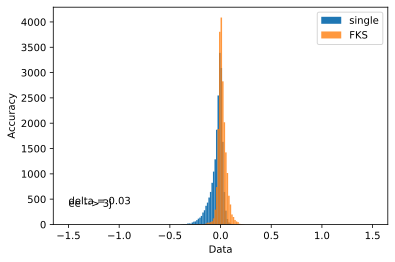

In [24]:
plt.hist(diff, density=False, bins=mybins, label='single')
plt.hist(diff_FKS, density=False, bins=mybins, label='FKS', alpha=0.8)
plt.ylabel('Accuracy')
plt.xlabel('Data')
plt.text(-1.5,400,'delta = '+str(delta_cut))
plt.text(-1.5,350,'ee --> '+str(n_final)+'j')
plt.legend()

In [25]:
logdiff = np.log10(np.abs(diff))
logdiff_FKS = np.log10(np.abs(diff_FKS))

In [26]:
mybins = np.histogram_bin_edges(logdiff, bins=200, range=(-4,1))

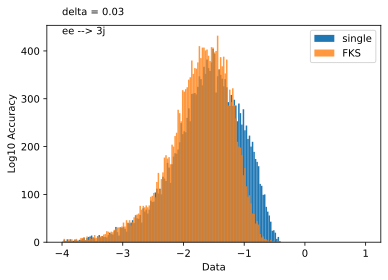

In [27]:
plt.hist(logdiff, density=False, bins=mybins, label='single')
plt.hist(logdiff_FKS, density=False, bins=mybins, label='FKS', alpha=0.8)
plt.ylabel('Log10 Accuracy')
plt.xlabel('Data')
plt.text(-4,475,'delta = '+str(delta_cut))
plt.text(-4,435,'ee --> '+str(n_final)+'j')
plt.legend()

## Exercises ##

1. Checking the cross section predicitions:

   1. Order the inference test data (i.e. NJ_treevals_test from the data set momenta_test) by the size to see which points give the largest contributions to the cross section. 
   
   2. Compare these points (say the largest 10 values) against the inferred values from the single and FKS ensemble networks.
   
   3. Compute the cross section from all three approaches and see which one gave the best approximation
   
2. Higher multiplicity example:

   1. Create a new NJet order file for e+e- -> 5j (e.g. 11 -11 -> 1 -1 21 21 21) and use it to create the contract file for the NJet link (njet.py -o NJ_contract_ee5j_tree.lh).
   
   2. Run the code again to see how well the network trains - do we need more training data than for lower multiplicities?